# **Sales Price Study Notebook**

## Objectives

* Answer the first business requirement:
    * Enable the customer to visualize which features of the dataset are most closely correlated to the property price.
        
## Inputs
        
* outputs/datasets/collection/HousePricesData.csv

        
## Outputs
        
* Generate code that answers business requirement 1 and can be used to build the Streamlit App.

## Additional comments

* We will be applying the methodology described in https://github.com/Code-Institute-Solutions/churnometer/blob/main/jupyter_notebooks/02%20-%20Churned%20Customer%20Study.ipynb, adapting it to our database and business requirements.
        

---

## Change working directory

* We use os.getcwd() to access the current directory.

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/P5-heritage-housing-issues/jupyter_notebooks'

## Access the parent directory
* We want to make the parent of the current directory the new current directory.
    * os.path.dirname() gets the parent directory
    * os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("A new current directory has been set")

A new current directory has been set


## Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/P5-heritage-housing-issues'

---

## Import libraries

In [4]:
# load data
import pandas as pd
# data exploration
from pandas_profiling import ProfileReport
# correlation study
from feature_engine.encoding import OneHotEncoder
# package for scientific computing
import numpy as np
# plot and graphs visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
# PPS study
import ppscore as pps

---

## Load data

* Load the dataset as a pandas DataFrame and assign it to our dataframe df_prices
* View the data in the df_prices variable

In [5]:
df_prices = (pd.read_csv("outputs/datasets/cleaned/HousePricesCleaned.csv"))
df_prices.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.000000,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.000000,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.000000,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,0.0,2.869214,No,216,ALQ,540,642,Unf,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,0.0,4.000000,Av,655,GLQ,490,836,RFn,2000.0,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


## Data Exploration

* We want to get more familiar with the dataset, check the variables. Determine their type, distribution and missing levels. We will use this exploration to create an image of what these variables mean in our project's context.
* We will use Panda's Profile Report (https://github.com/ydataai/ydata-profiling/blob/develop/README.md) to get an analysis of each of our variables, see the missing data levels, range and so on.
    * We notice there are 20 numerical and 4 categorical variables.

In [6]:
pandas_report = ProfileReport(df=df_prices, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Correlation Study

* We will use Pearson's and Sperman's correlation tests. As both only consider numerical variables, we will use OneHotEncoder to transform the categorical data. The documentation can be found here https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
* We use OneHotEncoder to replace the categorical variables with a combination of binary variables (which takes value 0 or 1) where each new binary variable is related to a label from the categorical variable.

In [7]:
encoder = OneHotEncoder(variables=df_prices.columns[df_prices.dtypes=='object'].to_list(), drop_last=False)
df_ohe = encoder.fit_transform(df_prices)
print(df_ohe.shape)
df_ohe.head(3)

(1460, 38)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtFinSF1,BsmtUnfSF,GarageArea,GarageYrBlt,GrLivArea,LotArea,LotFrontage,...,BsmtFinType1_BLQ,BsmtFinType1_LwQ,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_None,GarageFinish_Fin,KitchenQual_Gd,KitchenQual_TA,KitchenQual_Ex,KitchenQual_Fa
0,856,854.0,3.0,706,150,548,2003.0,1710,8450,65.0,...,0,0,1,0,0,0,1,0,0,0
1,1262,0.0,3.0,978,284,460,1976.0,1262,9600,80.0,...,0,0,1,0,0,0,0,1,0,0
2,920,866.0,3.0,486,434,608,2001.0,1786,11250,68.0,...,0,0,1,0,0,0,1,0,0,0


* We will create a few functions to help us in our correlation analysis.

In [8]:
def heatmap_correlation(df, threshold, title, figsize=(20,12), annot_size = 8):
  """
  Function to create heatmap using Pearson's and Spearman's correlations.
  """
  if len(df.columns) > 1:
    # we create the mask for the upper diagonal and
    # show only values greater than the threshold
    mask = np.zeros_like(df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[abs(df) < threshold] = True

    # we plot the heatmap
    fig, axes = plt.subplots(figsize=figsize)
    sns.heatmap(data=df, annot=True, xticklabels=True, yticklabels=True,
                mask=mask, cmap='viridis', annot_kws={"size": annot_size},
                ax=axes, linewidth=0.5).set(title=title)
    plt.ylim(len(df.columns),0)

def calculate_correlation(df):
  """
  Function to calculate correlations.
  """
  df_corr_spearman = df.corr(method="spearman")
  df_corr_spearman.name = 'corr_spearman'
  df_corr_pearson = df.corr(method="pearson")
  df_corr_pearson.name = 'corr_pearson'

  return df_corr_pearson, df_corr_spearman

def display_correlation(df_corr_pearson, df_corr_spearman, CorrThreshold,
                      figsize=(20,12), annot_size=8):
  """
  Function to display the correlations.
  """

  print("\n")
  heatmap_correlation(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, annot_size=annot_size,
                      title="*** Heatmap: Spearman Correlation *** \n Evaluates monotonic relationship")

  print("\n")
  heatmap_correlation(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, annot_size=annot_size,
                      title="*** Heatmap: Pearson Correlation *** \n Evaluates the linear relationship")

In [9]:
df_corr_pearson, df_corr_spearman = calculate_correlation(df_ohe)


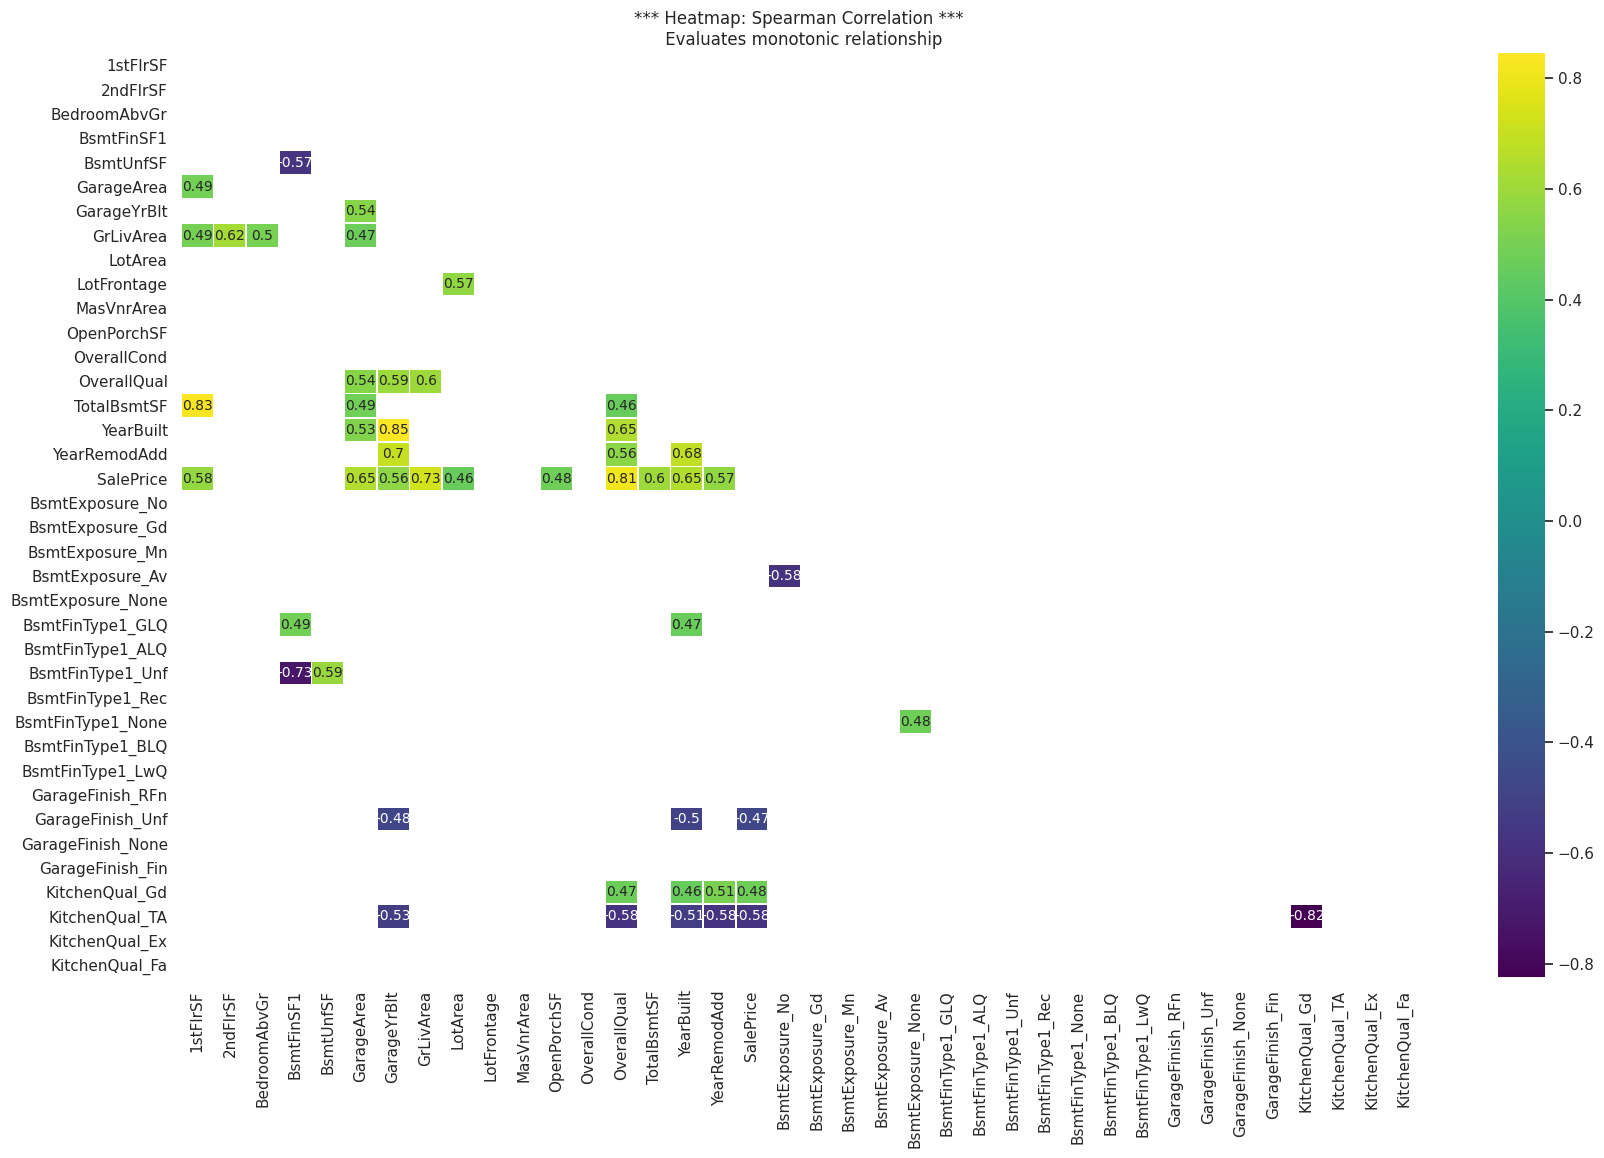

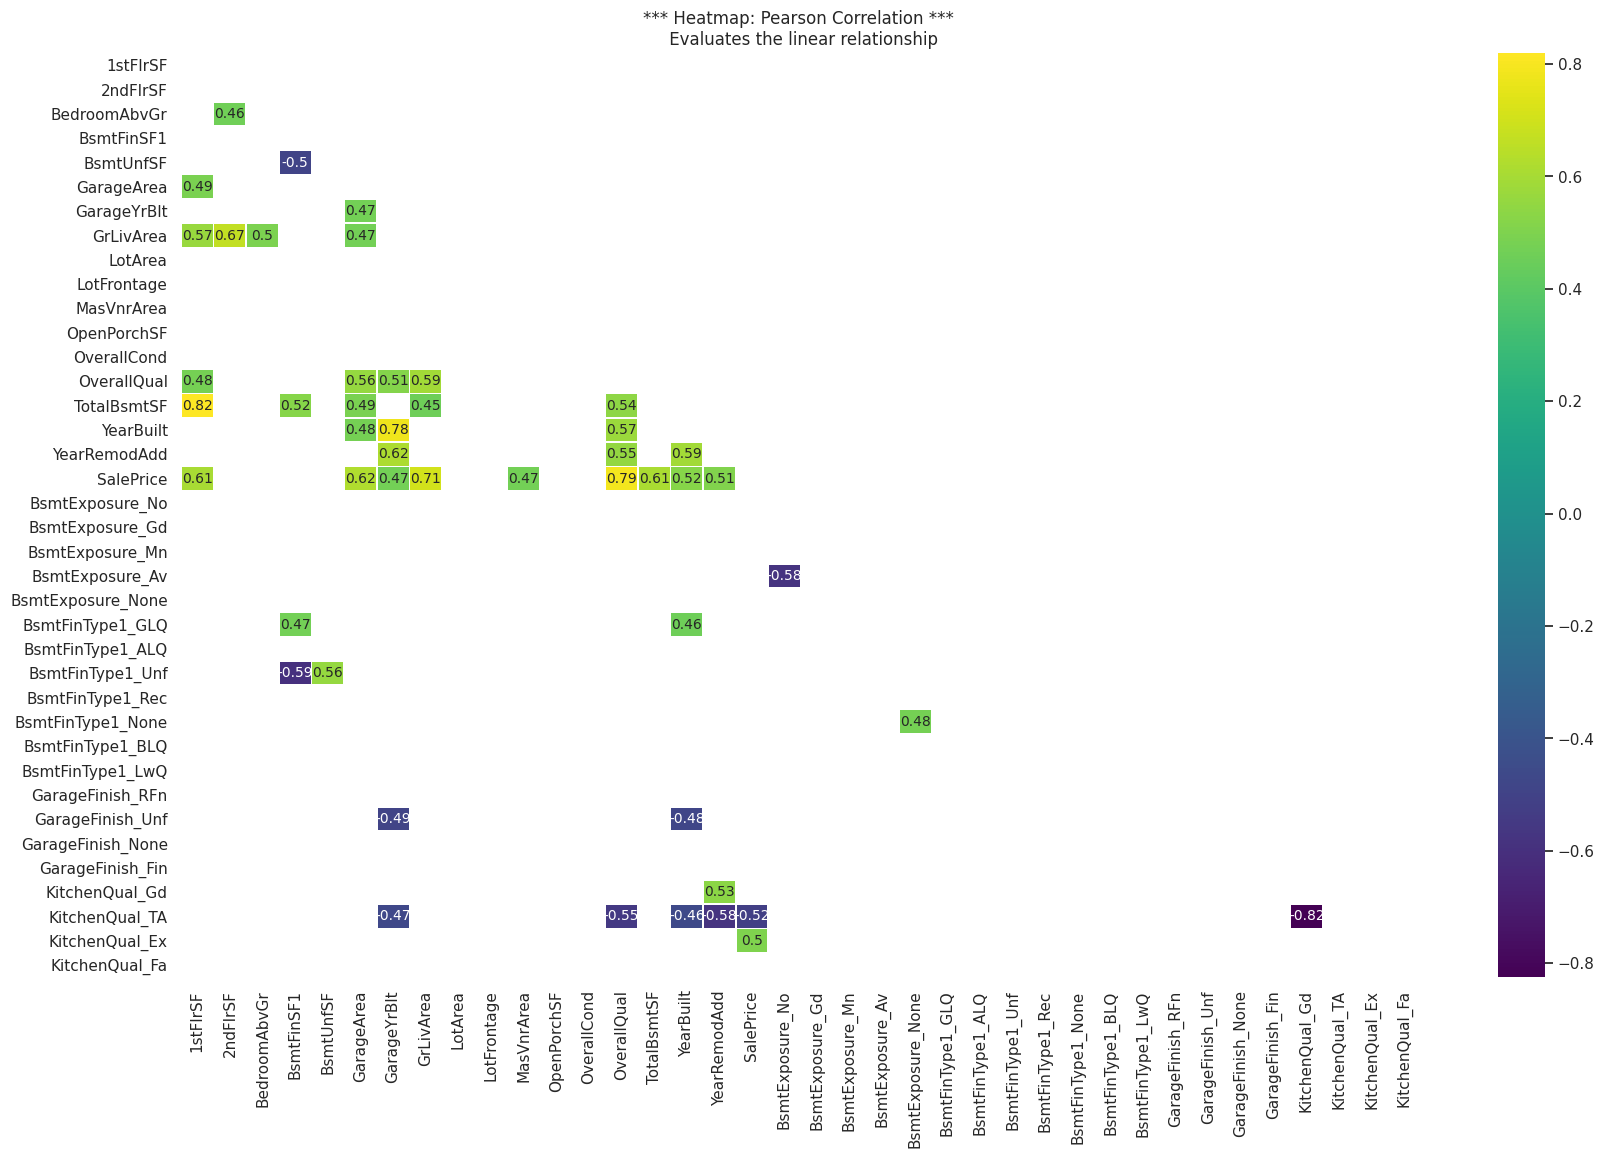

In [10]:
display_correlation(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman,
                  CorrThreshold = 0.45,
                  figsize=(20,12), annot_size=10)

* In this dataset, the target variable is SalePrice, so only look at correlations with SalePrice, and sort values by their absolute value, using .sort_values(key=abs, ascending=False). We know the first value will be the target variable itself, so we eliminate it by starting at the second position with [1:]. We will be looking at the top ten correlations in this study.
* We show the top ten values for both Spearman's and Pearson's correlations.

In [11]:
corr_spearman = df_ohe.corr(method='spearman')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_spearman

OverallQual       0.809829
GrLivArea         0.731310
YearBuilt         0.652682
GarageArea        0.649379
TotalBsmtSF       0.602725
KitchenQual_TA   -0.581803
1stFlrSF          0.575408
YearRemodAdd      0.571159
GarageYrBlt       0.563256
KitchenQual_Gd    0.478583
Name: SalePrice, dtype: float64

In [12]:
corr_pearson = df_ohe.corr(method='pearson')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_pearson

OverallQual       0.790982
GrLivArea         0.708624
GarageArea        0.623431
TotalBsmtSF       0.613581
1stFlrSF          0.605852
YearBuilt         0.522897
KitchenQual_TA   -0.519298
YearRemodAdd      0.507101
KitchenQual_Ex    0.504094
MasVnrArea        0.472614
Name: SalePrice, dtype: float64

We merge both correlations and avoid duplications by using set()

In [13]:
top_n = 10
set(corr_pearson[:top_n].index.to_list() + corr_spearman[:top_n].index.to_list())

{'1stFlrSF',
 'GarageArea',
 'GarageYrBlt',
 'GrLivArea',
 'KitchenQual_Ex',
 'KitchenQual_Gd',
 'KitchenQual_TA',
 'MasVnrArea',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd'}

* We create a list of our top 12 most influential variables from the correlation study.

In [14]:
correlation_vars = ['1stFlrSF',
 'GarageArea',
 'GarageYrBlt',
 'GrLivArea',
 'KitchenQual_Ex',
 'KitchenQual_Gd',
 'KitchenQual_TA',
 'MasVnrArea',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd'] 
correlation_vars

['1stFlrSF',
 'GarageArea',
 'GarageYrBlt',
 'GrLivArea',
 'KitchenQual_Ex',
 'KitchenQual_Gd',
 'KitchenQual_TA',
 'MasVnrArea',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd']

## PPS study

* The predictive power score detects linear or non-linear relationships between two variables. It helps to find predictive patterns in the data.
* It  will give additional insights into our data, including finding potential best univariate predictors for our target variable.
* As it is data-type-agnostic we can use the df_prices dataframe, without converting our categorical variables.

* First we will create a pairplot in order to have a visual insight into the correlation between our variables. As there is a lot of data, we will only visualise the row and column for SalePrice.
    * In order to do so, we first create a list of all our variables

In [15]:
variables_list = list(df_prices.columns)
variables_list

['1stFlrSF',
 '2ndFlrSF',
 'BedroomAbvGr',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinType1',
 'BsmtUnfSF',
 'GarageArea',
 'GarageFinish',
 'GarageYrBlt',
 'GrLivArea',
 'KitchenQual',
 'LotArea',
 'LotFrontage',
 'MasVnrArea',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd',
 'SalePrice']

We will then display the row for SalePrice:

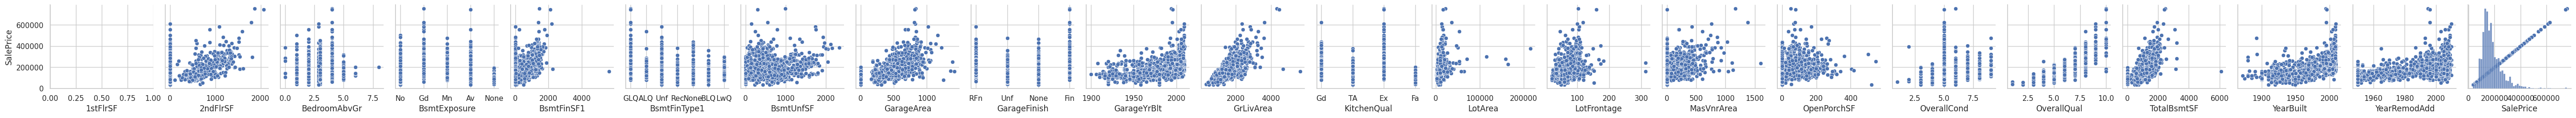

In [16]:
sns.pairplot(
    df_prices,
    x_vars=variables_list,
    y_vars=["SalePrice"],
)

And it's column:

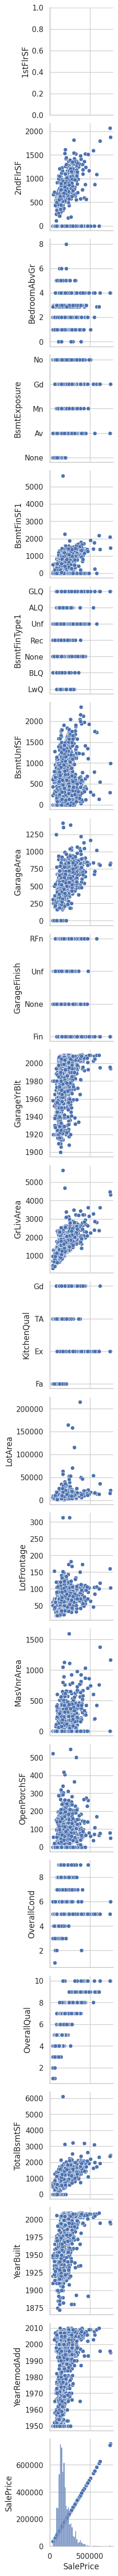

In [17]:
sns.pairplot(
    df_prices,
    x_vars=["SalePrice"],
    y_vars=variables_list,
)

* As for the correlation analysis, we will create a helper function to calculate and display the PPS

In [18]:
def heatmap_pps(df,threshold, figsize=(20,12), font_annot = 8):
    """
    Function to create heatmap using pps.
    """
    if len(df.columns) > 1:

      mask = np.zeros_like(df, dtype=np.bool)
      mask[abs(df) < threshold] = True

      fig, ax = plt.subplots(figsize=figsize)
      ax = sns.heatmap(df, annot=True, xticklabels=True,yticklabels=True,
                       mask=mask,cmap='rocket_r', annot_kws={"size": font_annot},
                       linewidth=0.05,linecolor='grey')
      
      plt.ylim(len(df.columns),0)
      plt.show()

def CalculatePPS(df):
  """
  Function to calculate pps.
  """
  pps_matrix_raw = pps.matrix(df)
  pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

  pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
  print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
  print(pps_score_stats.round(3))

  return pps_matrix

def DisplayPPS(pps_matrix,PPS_Threshold,
                      figsize=(20,12), font_annot=8 ):
  """
  Function to display the pps.
  """
  print("\n")
  print("*** Heatmap: Power Predictive Score (PPS) ***")
  print(f"PPS detects linear or non-linear relationships between two columns.\n"
        f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
  heatmap_pps(df=pps_matrix,threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

* We will display the PPS threshold report to help us decide on a threshold for the PPS heatmap
    * We can see that the top 25% of our variables have a PPS score superior to 0.076 with a maximum score of 0.625. Our mean PPS score is of 0.059

In [19]:
pps_matrix = CalculatePPS(df_prices)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  462.0  0.059  0.104  0.0  0.0  0.0  0.076  0.625


* For further insight, we will display the list of our predictors (features) and their ppscore regarding our target variable, SalePrice

    * We notice that our top ten predictive features have a ppscore superior to 0.06. We will therefore select that value as our heatmap threshold.

In [20]:
df_pps = pps.predictors(df_prices, "SalePrice", output="df", sorted=True)
df_pps

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,OverallQual,SalePrice,0.440962,regression,True,mean absolute error,55533.656164,31045.438267,DecisionTreeRegressor()
1,KitchenQual,SalePrice,0.261966,regression,True,mean absolute error,55533.656164,40985.702734,DecisionTreeRegressor()
2,YearBuilt,SalePrice,0.198485,regression,True,mean absolute error,55533.656164,44511.073059,DecisionTreeRegressor()
3,GarageArea,SalePrice,0.187993,regression,True,mean absolute error,55533.656164,45093.723468,DecisionTreeRegressor()
4,GarageYrBlt,SalePrice,0.158649,regression,True,mean absolute error,55533.656164,46723.306998,DecisionTreeRegressor()
5,YearRemodAdd,SalePrice,0.143284,regression,True,mean absolute error,55533.656164,47576.566795,DecisionTreeRegressor()
6,GarageFinish,SalePrice,0.120006,regression,True,mean absolute error,55533.656164,48869.259384,DecisionTreeRegressor()
7,GrLivArea,SalePrice,0.100166,regression,True,mean absolute error,55533.656164,49971.091218,DecisionTreeRegressor()
8,BsmtFinType1,SalePrice,0.070739,regression,True,mean absolute error,55533.656164,51605.279676,DecisionTreeRegressor()
9,LotFrontage,SalePrice,0.065822,regression,True,mean absolute error,55533.656164,51878.335878,DecisionTreeRegressor()


* We will now display the heatmap, showing values above our selected threshold of 0.06



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



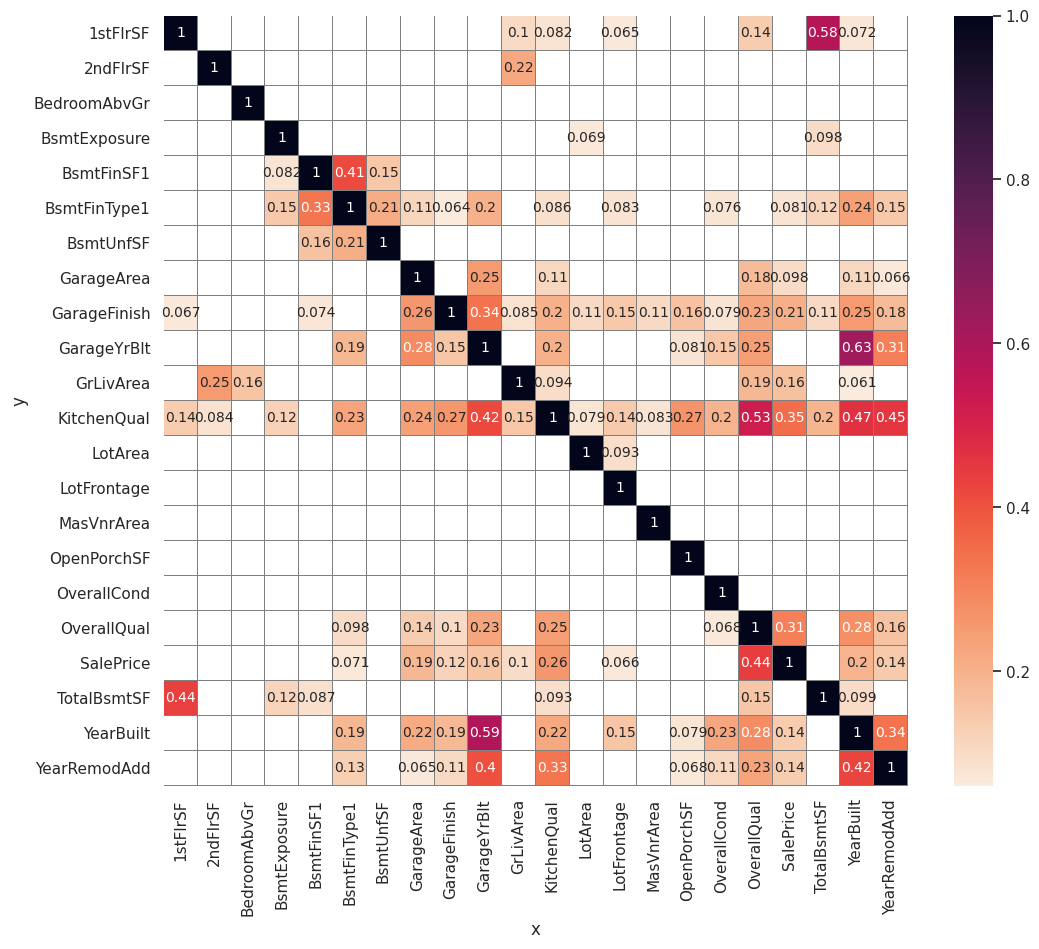

In [21]:
DisplayPPS(pps_matrix = pps_matrix, PPS_Threshold =0.06,
                  figsize=(12,10), font_annot=10)

* We create a list with our top 10 PPS predictors

In [22]:
top_n = 10
df_top_pps = df_pps[:top_n]
pps_vars = df_top_pps['x'].tolist()
pps_vars

['OverallQual',
 'KitchenQual',
 'YearBuilt',
 'GarageArea',
 'GarageYrBlt',
 'YearRemodAdd',
 'GarageFinish',
 'GrLivArea',
 'BsmtFinType1',
 'LotFrontage']

* Just as a reminder, let's display the most correlated features

In [23]:
correlation_vars

['1stFlrSF',
 'GarageArea',
 'GarageYrBlt',
 'GrLivArea',
 'KitchenQual_Ex',
 'KitchenQual_Gd',
 'KitchenQual_TA',
 'MasVnrArea',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd']

* We combine our top correlation features and our top PPS features to get the list of most influential variables using set to avoid duplicates.
    * We will remove the OneHotEncoder variables related to the kitchen quality as the categorical variable "KitchenQual" represents them. They did confirm that the higher the quality of the kitchen, the highest it's influence.
    * We will also remove "MasVnrArea" as we know from our data exploration that it contains more than 50% of zero values.

In [24]:
set(pps_vars + correlation_vars)

{'1stFlrSF',
 'BsmtFinType1',
 'GarageArea',
 'GarageFinish',
 'GarageYrBlt',
 'GrLivArea',
 'KitchenQual',
 'KitchenQual_Ex',
 'KitchenQual_Gd',
 'KitchenQual_TA',
 'LotFrontage',
 'MasVnrArea',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd'}

* We create a list of our most influencial variables

In [25]:
vars_to_study = ['1stFlrSF',
 'BsmtFinType1',
 'GarageArea',
 'GarageFinish',
 'GarageYrBlt',
 'GrLivArea',
 'KitchenQual',
 'LotFrontage',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd']

## EDA on influential variables

* We will now conduct an Exporatory Data Analaysis with the features that have the most correlation to our target variable, SalePrice.

* We create a separate DataFrame for the EDA by adding SalePrice so that we can use data visualization to draw insights about the relationship between each feature and the target.

In [26]:
df_eda = df_prices.filter(vars_to_study + ['SalePrice'])
df_eda.head()

,1stFlrSF,BsmtFinType1,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotFrontage,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,GLQ,548,RFn,2003.0,1710,Gd,65.0,7,856,2003,2003,208500
1,1262,ALQ,460,RFn,1976.0,1262,TA,80.0,6,1262,1976,1976,181500
2,920,GLQ,608,RFn,2001.0,1786,Gd,68.0,7,920,2001,2002,223500
3,961,ALQ,642,Unf,1998.0,1717,Gd,60.0,7,756,1915,1970,140000
4,1145,GLQ,836,RFn,2000.0,2198,Gd,84.0,8,1145,2000,2000,250000


### Target variable analysis

* Distribution of SalePrice

    * We will start by having a look at the distribution of our target variable through a histogram:

    - We can see that our target variable is skewed to the right. This is due to the fact that a few houses sell for a very high price

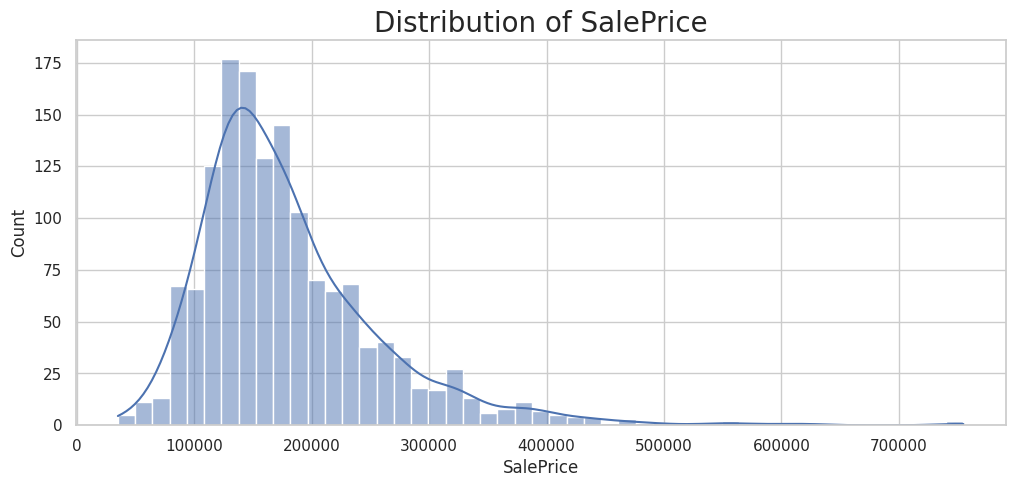

In [27]:
def plot_target_hist(df, target_var):
  """
  Function to plot a histogram of the target.
  """
  plt.figure(figsize=(12, 5))
  sns.histplot(data=df, x=target_var, kde=True)
  plt.title(f"Distribution of {target_var}", fontsize=20)       
  plt.show()

plot_target_hist(df_eda, 'SalePrice')

### Bivariate plots

* We will plot the sale price in relation to our selected features in order to answer our first business requirement, "discovering how the house attributes correlate with the sale price".

    * We notice that that higher sale prices tend to be associated to higher value features. This is true for all our plot types:  linear regression plots, box plots as well as line plots (time variables).
    * As for our target variable distribution, we notice some outlying values. We will work on these in the feature engineering notebook to prepare the data for modeling.

<Figure size 1200x500 with 0 Axes>

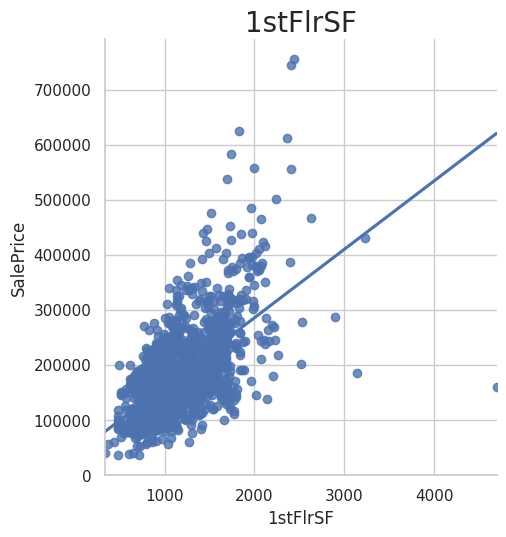

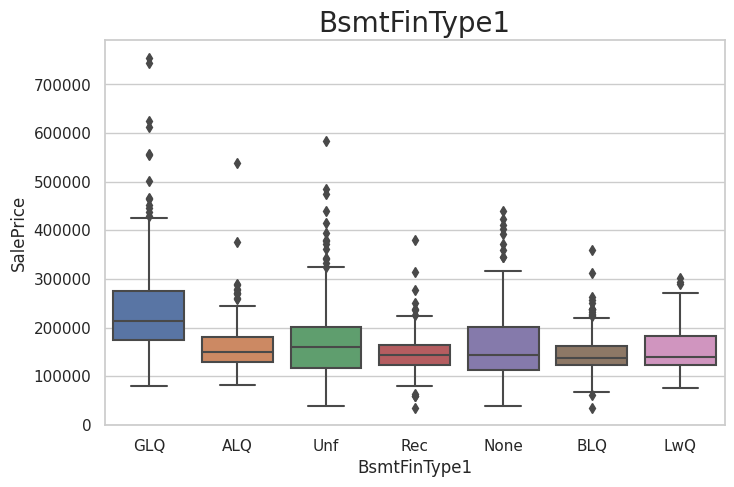

<Figure size 1200x500 with 0 Axes>

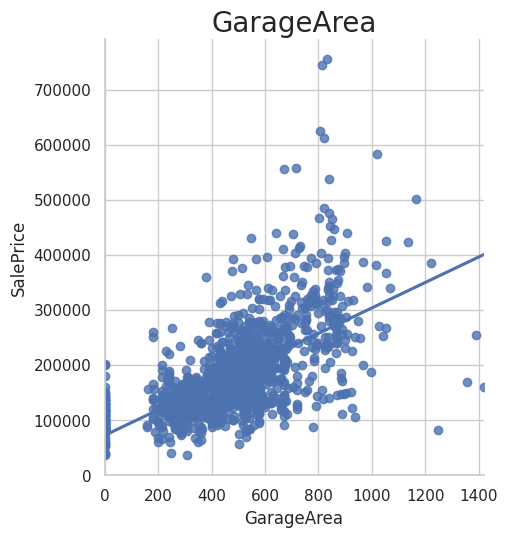

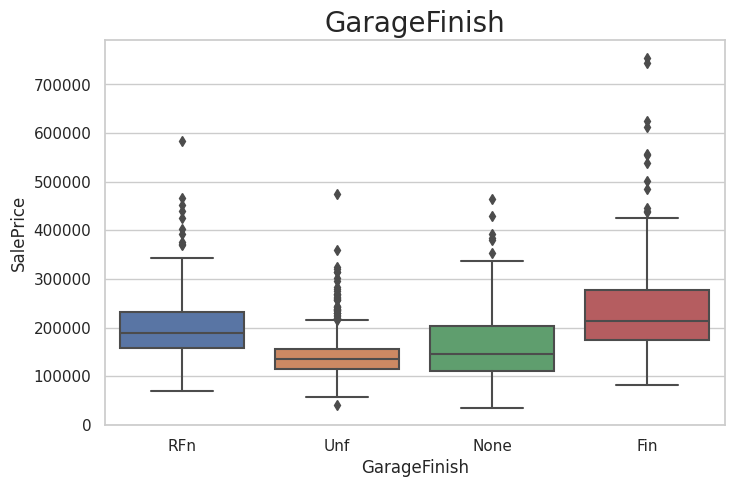

<Figure size 1200x500 with 0 Axes>

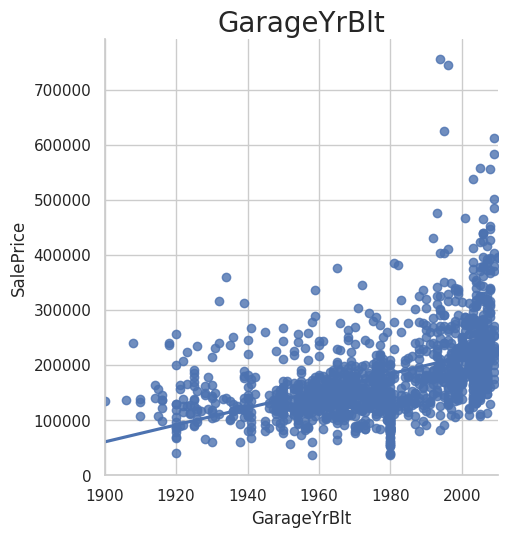

<Figure size 1200x500 with 0 Axes>

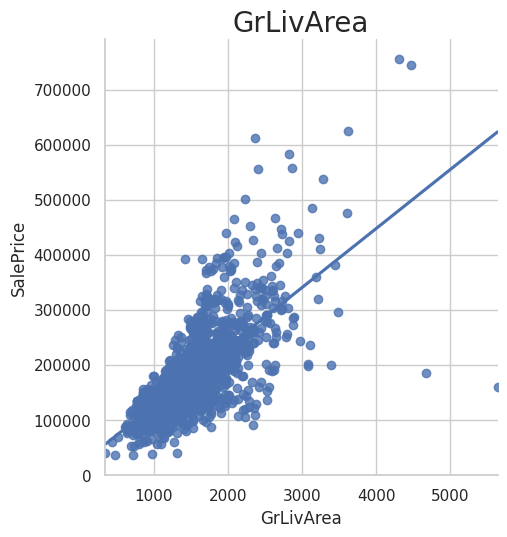

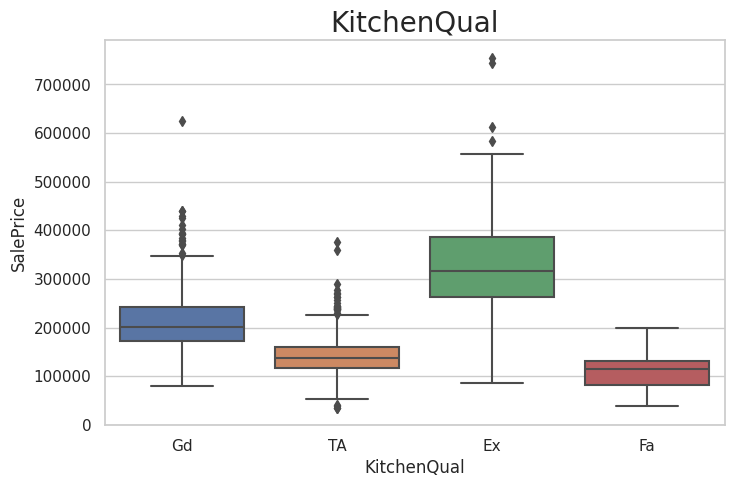

<Figure size 1200x500 with 0 Axes>

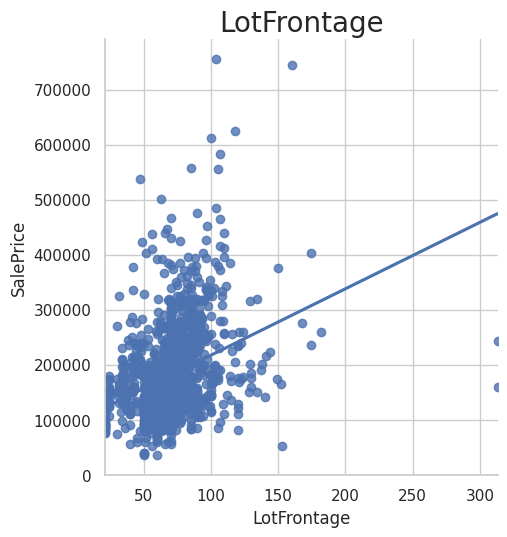

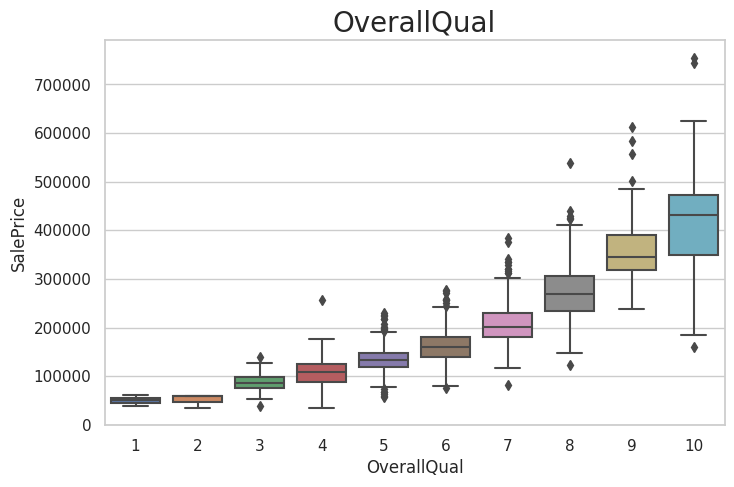

<Figure size 1200x500 with 0 Axes>

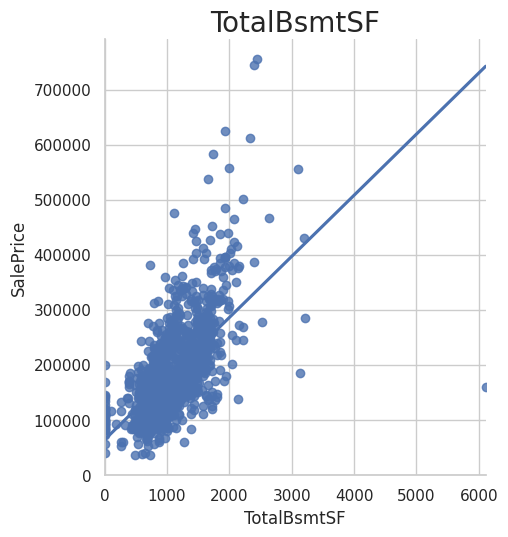

In [ ]:
def plot_box(df, col, target_var):
  """
  Function to create a box plot of the target and
  categorical variables.
  """
  plt.figure(figsize=(8, 5))
  sns.boxplot(data=df, x=col, y=target_var) 
  plt.title(f"{col}", fontsize=20)
  plt.show()

def plot_line(df, col, target_var):
  """
  Function to create a line plot of the target and
  time variables (years).
  """
  plt.figure(figsize=(12, 5))
  sns.lineplot(data=df, x=col, y=target_var)
  plt.title(f"{col}", fontsize=20)        
  plt.show()

def plot_lm(df, col, target_var):
  """
  Function to create linear regression plots of the target and
  features with continuous values.
  """
  plt.figure(figsize=(12, 5))
  sns.lmplot(data=df, x=col, y=target_var, ci=None)
  plt.title(f"{col}", fontsize=20)       
  plt.show()

target_var = 'SalePrice'
time = ['YearBuilt', 'YearRemodAdd']

for col in vars_to_study:
  if len(df_eda[col].unique()) <= 10:
    plot_box(df_eda, col, target_var)
    print("\n\n")
  else:
    if col in time:
      plot_line(df_eda, col, target_var)
      print("\n\n")
    else:
      plot_lm(df_eda, col, target_var)
      print("\n\n")

---

## Conclusions

- From our correlation analysis we have determined the most influential variables. They confirm our three hypothesises:
    - The size of the house is positively correlated to the sale price. We can see this through the features 1stFlrSF, GarageArea, GrLivArea, LotFrontage and TotalBsmtSF.
    - The quality/condition of the property is positively correlated to the sale price. Features such as BsmtFinType1, GarageFinish,KitchenQual or OverallQual confirm this.
    - The age of a house is negatively correlated to the sale price. GarageYrBlt, YearBuilt and YearRemodAdd confirm this hypothesis.